Problem Overview:
The goal of this notebook is to choose an aspect of design criteria that we will implement into the original rocket landing model given to us.
For this project, we will improve on the realism of the defining spaces by assuming the rocket is rolling. Rolling is defined as a non-zero angular velocity among its longest axis for the initial condition, defined as omega in the problem definition.

![P1](P1.png "P1")

This implies we give the rocket a constant to define the rate at which omega will change, defined as ROTATION_ACCEL in the environmental parameters of the code.

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant


# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
ROTATION_ACCEL = .2  # rotation constant
# DRAG_COEFF = .05

Here we define the state space and time step matrix that we will use to add our spin.

In [3]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        

        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME,0])
        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.,0]) * action
        delta_state_spin = ROTATION_ACCEL * FRAME_TIME * t.tensor([0,0,-1]) * action
        # Update velocity
        state = state + delta_state + delta_state_gravity + delta_state_spin
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0],
                            [0, 1, 0],
                            [0, 0, 1]])
        state = t.matmul(step_mat, state)

        return state

Changing the given neural network code appears to have drastic impact on the resulting convergence plots.

In [4]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Sigmoid(),
            nn.Linear(dim_hidden, dim_output),

            # You can add more layers here
            nn.Tanh(),

            
            

        )

    def forward(self, state):
        action = self.network(state)
        return action

Our initial state is define here as a spin of 1 angle per time frame
The function to minimze is also define by adding the square of omega

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0., 1]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2

Here I removed the visualize function from the loss loop due to carpal tunnel setting in from scrolling so much. Eventually after multiple runs, the graph settled nicely.

In [6]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        plt.plot(x,y)
        plt.plot(x,z)

[1] loss: 32.954
[2] loss: 18.106
[3] loss: 11.346
[4] loss: 7.416
[5] loss: 4.918
[6] loss: 3.281
[7] loss: 2.189
[8] loss: 1.427
[9] loss: 0.879
[10] loss: 0.537
[11] loss: 0.340
[12] loss: 0.226
[13] loss: 0.156
[14] loss: 0.113
[15] loss: 0.085
[16] loss: 0.068
[17] loss: 0.058
[18] loss: 0.052
[19] loss: 0.049
[20] loss: 0.047
[21] loss: 0.046
[22] loss: 0.045
[23] loss: 0.045
[24] loss: 0.044
[25] loss: 0.044
[26] loss: 0.044
[27] loss: 0.044
[28] loss: 0.044
[29] loss: 0.043
[30] loss: 0.043
[31] loss: 0.042
[32] loss: 0.015
[33] loss: 0.008
[34] loss: 0.004
[35] loss: 0.002
[36] loss: 0.001
[37] loss: 0.001
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


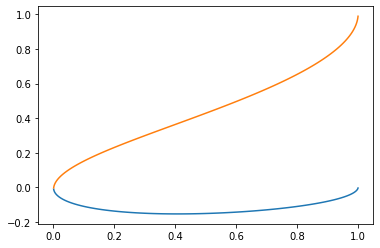

In [7]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 3  # state space dimensions
dim_hidden = 8  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

Here is our final plot representing our action space. Distance is the x-axis and the y-axis represents velocity (blue) and rolling angular velocity (orange).
As we can see, the two curves approach the optimal result of 0 at the end of the algorithm.
It's important to note the different results acheived from rerunning the exact same code. We know this is due to the neural network controller input as it ultimately relies on random inputs and "guesses" in the right direction. Which it happen to for this plot.

Text(0.5, 1.0, 'Loss vs iteration')

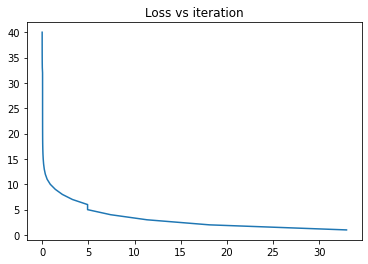

In [16]:
import numpy as np
from matplotlib import pyplot as plt
loss = [32.954, 18.106, 11.346, 7.416, 4.916,\
        4.918, 3.281, 2.189, 1.427, 0.879,\
        0.537, 0.340, 0.226, 0.156, 0.113,\
        0.085, 0.068, 0.058, 0.052, 0.049,\
        0.047, 0.046, 0.045, 0.045, 0.044,\
        0.044, 0.044, 0.044, 0.044, 0.043,\
        0.043, 0.042, 0.015, 0.008, 0.004,\
        0.002, 0.001, 0.000, 0.000, 0.000]
x = np.linspace(1, 40, num=40)
plt.plot(loss,x)
plt.title('Loss vs iteration')


Comparing the loss to the iterations shows us a logarithmic relation which makes sense given the algorithm. It appears to have converged upon the approximate solution fairly qucikly with refinements to the space happening in the later iterations.